In [3]:
import os
import time
import keras
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten , Dense, Activation,Dropout
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [4]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_val = x_train[40000:50000]
y_val = y_train[40000:50000]
x_train = x_train[0:40000]
y_train= y_train[0:40000]
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'Validation samples')
print(x_test.shape[0], 'test samples')

x_train shape: (40000, 32, 32, 3)
40000 train samples
10000 Validation samples
10000 test samples


In [5]:
print("Train samples:", x_train.shape, y_train.shape)
print("Validation samples:", x_val.shape, y_val.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (40000, 32, 32, 3) (40000, 1)
Validation samples: (10000, 32, 32, 3) (10000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [6]:
num_classes = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

In [7]:
x_train = (x_train/255) - 0.5
x_test = (x_test/255) - 0.5
x_val = (x_val/255) - 0.5
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [8]:
cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))
cnn.add(Flatten())
cnn.add(Dense(1024, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(10, activation='softmax'))
opt = keras.optimizers.RMSprop(lr=0.001, rho=0.9)
cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 128)         147584    
__________

In [10]:
alexNet = Sequential()
alexNet.add( Conv2D(48, kernel_size=(3,3),strides=(1,1), activation='relu', padding='same', input_shape=x_train.shape[1:] ) )
alexNet.add( MaxPooling2D(pool_size=(2,2),strides=(2,2)) )
alexNet.add( Conv2D(96, kernel_size=(3,3), activation='relu', padding='same') )
alexNet.add( MaxPooling2D(pool_size=(2,2),strides=(2,2)) )
alexNet.add( Conv2D(192, kernel_size=(3,3), activation='relu', padding='same') )
alexNet.add( Conv2D(192, kernel_size=(3,3), activation='relu', padding='same') )
alexNet.add( MaxPooling2D(pool_size=(2,2),strides=(2,2)) )
alexNet.add( Conv2D(256, kernel_size=(3,3), activation='relu', padding='same') )
alexNet.add( MaxPooling2D(pool_size=(2,2),strides=(2,2)) )
alexNet.add(Flatten())
alexNet.add(Dense(512, activation='tanh'))
alexNet.add(Dense(256, activation='tanh'))
alexNet.add(Dense(10, activation='softmax'))
alexNet.compile(loss= keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])


In [11]:
alexNet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 48)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 96)        41568     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 96)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 192)         166080    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 192)         331968    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 192)         0         
__________

In [12]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [13]:
from keras.models import Model
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = keras.layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = keras.layers.AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [14]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=keras.regularizers.l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x =keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [15]:
from keras.optimizers import Adam
resnetv1_20 = resnet_v1(input_shape=(32,32,3), depth=20)

resnetv1_20.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
resnetv1_20.summary()

Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_10[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [18]:
from random import seed
from random import random
from random import randrange

def subsample(x, y, ratio=1.0):
    x_bg = list()
    y_bg = list()
    n_sample = round(len(x) * ratio)
    while len(x_bg) < n_sample:
        index = randrange(len(x))
        x_bg.append(x[index])
        y_bg.append(y[index])
    return x,y
 

In [20]:
batch_size = 128
epochs=50

seed(random)
x_train_bg1,y_train_bg1 = subsample(x_train,y_train, 0.5)
x_train_bg2,y_train_bg2 = subsample(x_train,y_train, 0.5)
x_train_bg3,y_train_bg3 = subsample(x_train,y_train, 0.5)

In [21]:
cnnHistory = cnn.fit(x_train_bg1, y_train_bg1,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_val, y_val))

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 150s 4ms/step - loss: 1.7358 - acc: 0.3666 - val_loss: 1.8097 - val_acc: 0.3807
Epoch 2/50
40000/40000 [==============================] - 150s 4ms/step - loss: 1.3169 - acc: 0.5260 - val_loss: 1.1112 - val_acc: 0.5934
Epoch 3/50
40000/40000 [==============================] - 149s 4ms/step - loss: 1.1161 - acc: 0.6038 - val_loss: 1.0729 - val_acc: 0.6216
Epoch 4/50
40000/40000 [==============================] - 156s 4ms/step - loss: 0.9637 - acc: 0.6617 - val_loss: 0.9736 - val_acc: 0.6545
Epoch 5/50
40000/40000 [==============================] - 148s 4ms/step - loss: 0.8623 - acc: 0.7005 - val_loss: 0.8103 - val_acc: 0.7146
Epoch 6/50
40000/40000 [==============================] - 141s 4ms/step - loss: 0.7832 - acc: 0.7273 - val_loss: 0.7390 - val_acc: 0.7407
Epoch 7/50
40000/40000 [==============================] - 150s 4ms/step - loss: 0.7192 - acc: 0.7496 - val_loss: 0.7216 - 

In [22]:
cnn.save_weights('cnnWeights_bg.h5')

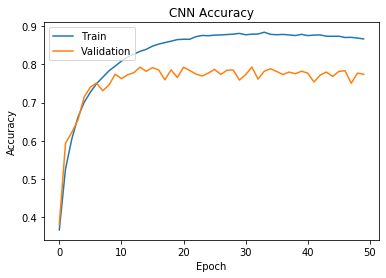

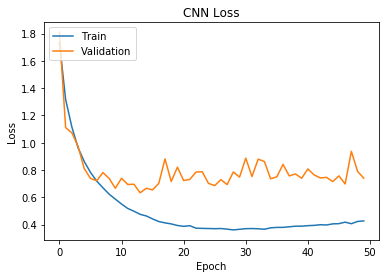

In [23]:
plt.plot(cnnHistory.history['acc'])
plt.plot(cnnHistory.history['val_acc'])
plt.title('CNN Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(cnnHistory.history['loss'])
plt.plot(cnnHistory.history['val_loss'])
plt.title('CNN Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [24]:
alexNetHistory = alexNet.fit(x_train_bg2, y_train_bg2,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_val, y_val))

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 194s 5ms/step - loss: 1.7623 - acc: 0.3531 - val_loss: 1.4674 - val_acc: 0.4794
Epoch 2/50
40000/40000 [==============================] - 194s 5ms/step - loss: 1.2155 - acc: 0.5651 - val_loss: 1.0230 - val_acc: 0.6378
Epoch 3/50
40000/40000 [==============================] - 194s 5ms/step - loss: 0.9226 - acc: 0.6718 - val_loss: 0.8888 - val_acc: 0.6829
Epoch 4/50
40000/40000 [==============================] - 194s 5ms/step - loss: 0.7264 - acc: 0.7437 - val_loss: 0.8873 - val_acc: 0.6999
Epoch 5/50
40000/40000 [==============================] - 194s 5ms/step - loss: 0.5690 - acc: 0.8012 - val_loss: 0.9144 - val_acc: 0.7030
Epoch 6/50
40000/40000 [==============================] - 194s 5ms/step - loss: 0.4449 - acc: 0.8433 - val_loss: 0.8628 - val_acc: 0.7336
Epoch 7/50
40000/40000 [==============================] - 194s 5ms/step - loss: 0.3366 - acc: 0.8828 - val_loss: 0.7551 - 

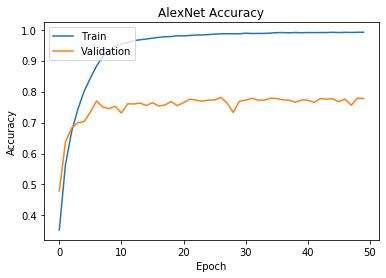

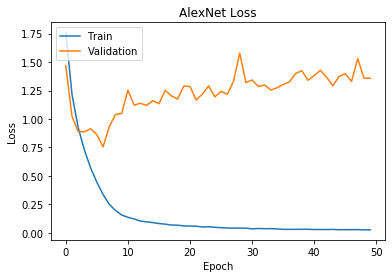

In [25]:
plt.plot(alexNetHistory.history['acc'])
plt.plot(alexNetHistory.history['val_acc'])
plt.title('AlexNet Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(alexNetHistory.history['loss'])
plt.plot(alexNetHistory.history['val_loss'])
plt.title('AlexNet Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [26]:
alexNet.save_weights('alexNetWeights_bg.h5')

In [27]:
resNetHistory=resnetv1_20.fit(x_train_bg3, y_train_bg3,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_val, y_val))

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 627s 16ms/step - loss: 1.6007 - acc: 0.4681 - val_loss: 2.1609 - val_acc: 0.3835
Epoch 2/50
40000/40000 [==============================] - 625s 16ms/step - loss: 1.1945 - acc: 0.6162 - val_loss: 1.3307 - val_acc: 0.5663
Epoch 3/50
40000/40000 [==============================] - 626s 16ms/step - loss: 1.0090 - acc: 0.6862 - val_loss: 1.7464 - val_acc: 0.4977
Epoch 4/50
40000/40000 [==============================] - 625s 16ms/step - loss: 0.8788 - acc: 0.7331 - val_loss: 1.3082 - val_acc: 0.6042
Epoch 5/50
40000/40000 [==============================] - 625s 16ms/step - loss: 0.7833 - acc: 0.7678 - val_loss: 1.1431 - val_acc: 0.6695
Epoch 6/50
40000/40000 [==============================] - 626s 16ms/step - loss: 0.7053 - acc: 0.7975 - val_loss: 1.0685 - val_acc: 0.7000
Epoch 7/50
40000/40000 [==============================] - 627s 16ms/step - loss: 0.6511 - acc: 0.8187 - val_loss: 1.

In [28]:
resnetv1_20.save_weights('resnetv1_20Weights_bg.h5')

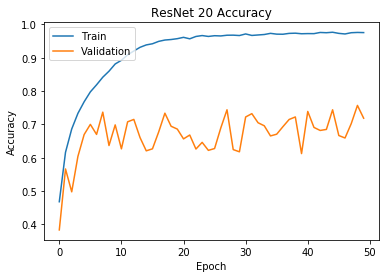

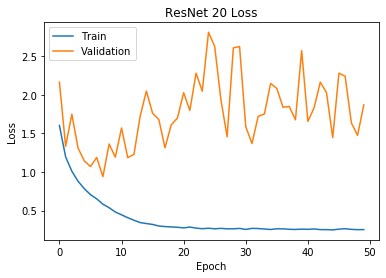

In [29]:
plt.plot(resNetHistory.history['acc'])
plt.plot(resNetHistory.history['val_acc'])
plt.title('ResNet 20 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(resNetHistory.history['loss'])
plt.plot(resNetHistory.history['val_loss'])
plt.title('ResNet 20 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [30]:
resnetv1_20.save('resnet_model.h5') 
alexNet.save('alexnet_model.h5') 
cnn.save('cnn_model.h5') 